In [1]:
import math
import numpy as np
import pandas as pd
import sys
import itertools
from functions import *
from mining_functions import *
from collections import Counter
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')
gitpath = '/Documents/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
df = pd.read_csv(get_path(path = gitpath) + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
# dfx = pd.read_csv('C:\Users\Sarah\Documents\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
df["student"] = df["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()
df["Family_tool"]=df["Family_tool"].str.capitalize()
df["Family_default"]=df["Family_default"].str.capitalize()
df["Family_both"]=df["Family_both"].str.capitalize()

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')

In [42]:
def make_hist(seq_of_interest,freq_HL,freq_LL):
    fig, axs = plt.subplots(1,figsize=(12,2.5))
    ymax= max(max(freq_HL),max(freq_LL))
    bins = range(0,ymax,1)
    plt.hist(freq_HL,color ='r',alpha = 0.5,bins = bins)
    plt.hist(freq_LL,color = 'b',alpha = 0.5,bins = bins)
    plt.title("Use of the sequence ''{0}'' by HL (red) and LL (blue)".format(seq_of_interest))
    return None

def run_frequency_analysis(seq_of_interest, blocks_HL, blocks_LL,sequence_counts):
    freq_HL = [''.join(seq).count(seq_of_interest) for seq in blocks_HL.values()]
    freq_LL = [''.join(seq).count(seq_of_interest) for seq in blocks_LL.values()]
    make_hist(seq_of_interest,freq_HL,freq_LL)
    plot = plot_heat_map(sequence_counts[seq_of_interest],seq_of_interest,('high','low'))
    print seq_of_interest, ":\t", stats.ttest_ind(freq_HL,freq_LL,equal_var=False)
    print '\t','HL<LL',stats.mannwhitneyu(freq_HL,freq_LL, alternative='less')
    print '\t','HL>LL',stats.mannwhitneyu(freq_HL,freq_LL, alternative='greater')
    return None

def run_frequency_analysis_with_merge(seq_of_interest, blocks_HL, blocks_LL,sequence_counts):
    freq_HL = [''.join([merged_actions[s] for s in seq]).count(seq_of_interest) for seq in blocks_HL.values()]
    freq_LL = [''.join([merged_actions[s] for s in seq]).count(seq_of_interest) for seq in blocks_LL.values()]
    make_hist(seq_of_interest,freq_HL,freq_LL)
    print seq_of_interest, ":\t", stats.ttest_ind(freq_HL,freq_LL,equal_var=False)
    print '\t','HL<LL',stats.mannwhitneyu(freq_HL,freq_LL, alternative='less')
    print '\t','HL>LL',stats.mannwhitneyu(freq_HL,freq_LL, alternative='greater')
    return None

# Story line
This notebook raises and explores hypotheses generated fom the analysis in the notebook  "temporal_sequence_infogain_mining.ipynb"

Here are the Hypotheses:
* CTsPTsP (HL)
    * TsP
        * Ts (**1.1**)
        * TP (**1.2**)
    * TsPTsP
        * TPTP (**2.1**)
* PCTcCTcC (LL)
    * TcC
        * Tc (**3.1**)
        * TC (**3.2**)
    * TcCTcC
        * TCTC (**4.1**)
* PCPCTcC (LL)
    * PC (**5.1**)
    * CP (**5.2**)
* PTsPC (HL)
    * PTs
    * PT (**6**)

## Frequency analysis of single blocks of actions -> Hypotheses 1.1 and 3.1
First we get the sequence of action of each students in blocks. Recall that we only look at students who had a low pre.
We also ignore the Interface (I) becasue they aren't interesting and we ignore the Test Other (To) because only 8 students do it.

In [4]:
students_Lpre = set(get_students('split pre','low'));H_post = set(get_students('split post t2','high'));L_post = set(get_students('split post t2','low'))
students_HL = H_post.intersection(students_Lpre)
students_LL = L_post.intersection(students_Lpre)
print "There are {0} low pre students, of which {1} are high learners and {2} low learners.".format(len(students_Lpre),len(students_HL),len(students_LL))

There are 74 low pre students, of which 38 are high learners and 36 low learners.


In [5]:
blocks_HL, time_coords_HL =  get_blocks_withTime_new(df,students_HL,"Family",start=False,ignore=['I','To'], as_list=True)
blocks_LL, time_coords_LL =  get_blocks_withTime_new(df,students_LL,"Family",start=False,ignore=['I','To'], as_list=True)
blocks_Lpre, time_coords_Lpre =  get_blocks_withTime_new(df,students_Lpre,"Family",start=False,ignore=['I','To'], as_list=True)

We may need to plot sequences so let's load them up

In [6]:
CUT_OFF = 0.35 #we keep only sequences used once by at least 20% of students
shortest_seq_length = 1
longest_seq_length = 10
B = 4  #number of bins
family_category = "Family"
sequence_counts = get_sequence_use_by_timebin(df,students_Lpre,family_category,
                                                          B,'split post t2','high','low',
                                                          shortest_seq_length,longest_seq_length,CUT_OFF)

Getting sequence use over 4 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.


In [7]:
#get all actions
actions = set(list(itertools.chain.from_iterable(blocks_Lpre.values())))
freqs_HL = {s:{a:0 for a in actions} for s in students_HL}
freqs_LL = {s:{a:0 for a in actions} for s in students_LL}
for student,seq in blocks_HL.iteritems():
    for action in seq:
        freqs_HL[student][action]+=1
for student,seq in blocks_LL.iteritems():
    for action in seq:
        freqs_LL[student][action]+=1

P :	Ttest_indResult(statistic=-0.18775671192769167, pvalue=0.85162812802894194)
	HL<LL MannwhitneyuResult(statistic=700.0, pvalue=0.571113415200732)
	HL>LL MannwhitneyuResult(statistic=700.0, pvalue=0.43315461546305928)
C :	Ttest_indResult(statistic=-2.2612367816278729, pvalue=0.027618004582543067)
	HL<LL MannwhitneyuResult(statistic=516.0, pvalue=0.034798463769704892)
	HL>LL MannwhitneyuResult(statistic=516.0, pvalue=0.9660264922742513)
Tb :	Ttest_indResult(statistic=0.4289937989878353, pvalue=0.6692087415855581)
	HL<LL MannwhitneyuResult(statistic=754.5, pvalue=0.78197780078741574)
	HL>LL MannwhitneyuResult(statistic=754.5, pvalue=0.22126738294286918)
Ts :	Ttest_indResult(statistic=0.21480538306708899, pvalue=0.83052642843086733)
	HL<LL MannwhitneyuResult(statistic=720.0, pvalue=0.65486956686243536)
	HL>LL MannwhitneyuResult(statistic=720.0, pvalue=0.34916223800547513)
Tc :	Ttest_indResult(statistic=-1.6343463070187461, pvalue=0.10727384879743844)
	HL<LL MannwhitneyuResult(statistic=

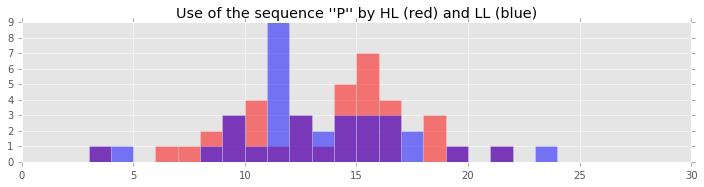

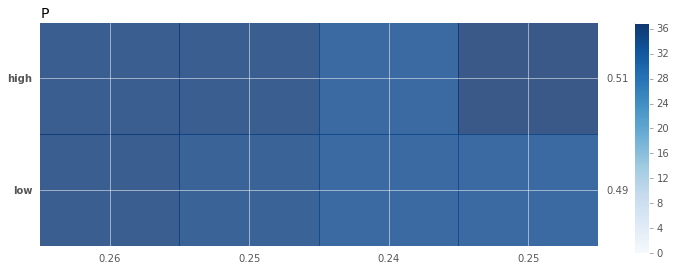

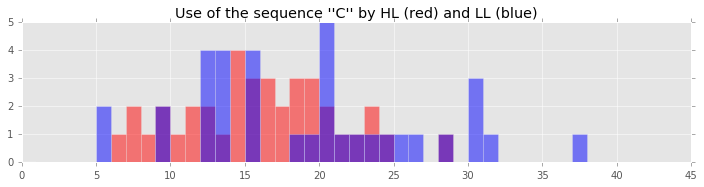

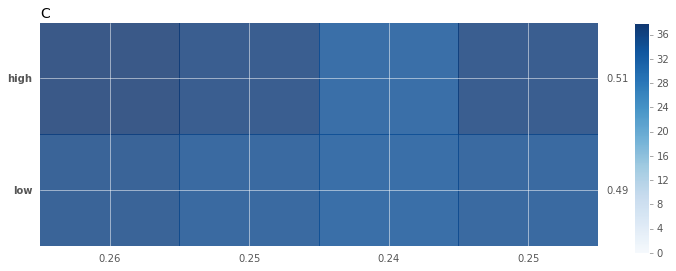

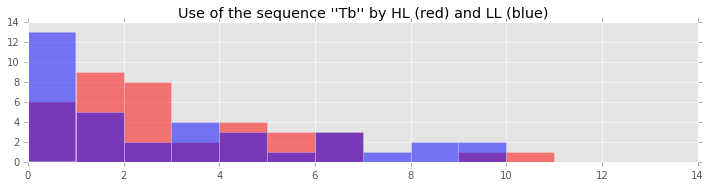

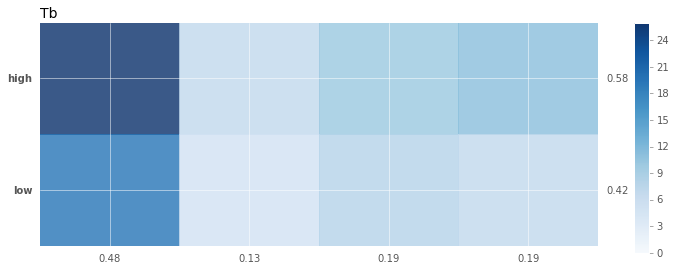

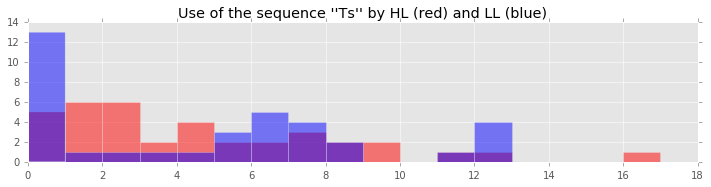

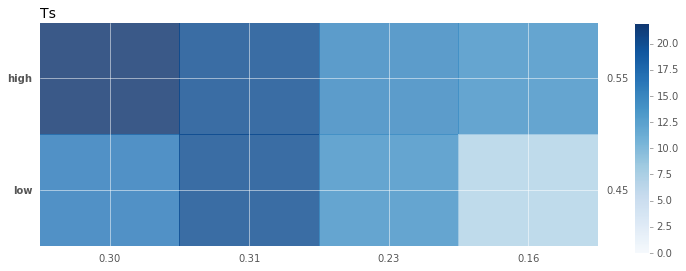

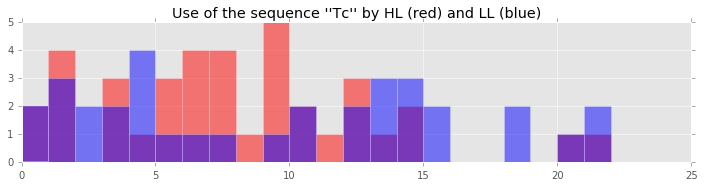

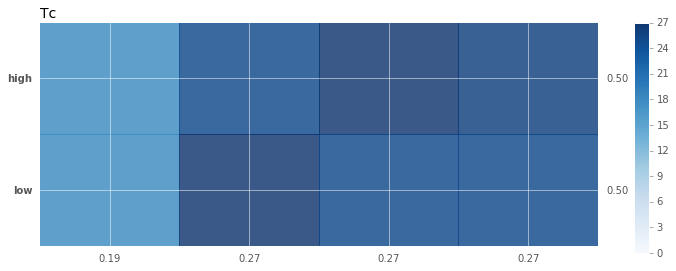

In [44]:
for action in actions:
    run_frequency_analysis(action,blocks_HL,blocks_LL,sequence_counts)

#### We notice that some students never Test simple (13 LL and 5 HL)
Several LL do many many Test complex actions, and perhaps have more Construct blocks. More LL students tend to do 6+ blocks of Test simple and Test basic.

Everyone Test simple and basic early as well as Test complex late. 

We can do some t-tests to confirm that most patterns above are not significant.

** <font color='blue'> Clearly, LL have more construction blocks ($p < 0.05$) </font> **

## Let's start digging into our Hypotheses
### Hypothesis 1.2: HL do more TsP? What about TP?
### Hypothesis 3.2: LL do more TcC? What about TC?

Ttest_indResult(statistic=1.3463696220425387, pvalue=0.18253484609988579)
MannwhitneyuResult(statistic=798.5, pvalue=0.89877708123305)


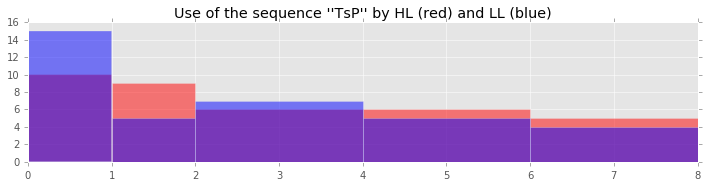

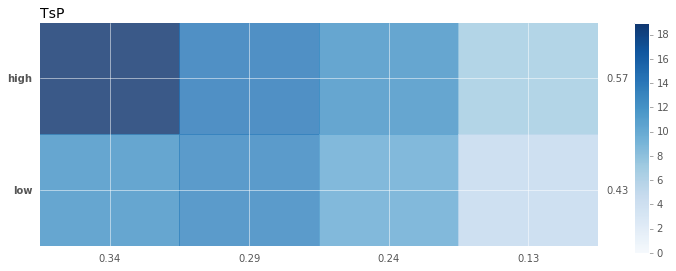

In [14]:
seq_of_interest = "TsP"
run_frequency_analysis('TsP',blocks_HL,blocks_LL,sequence_counts)

Ttest_indResult(statistic=-2.5221566382990575, pvalue=0.0146703082186999)
MannwhitneyuResult(statistic=513.5, pvalue=0.03215997937086728)


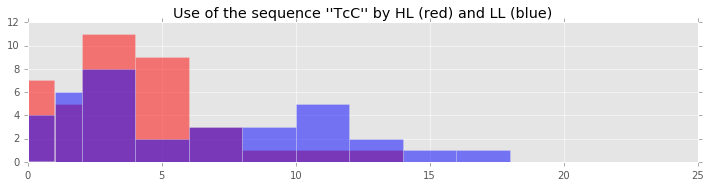

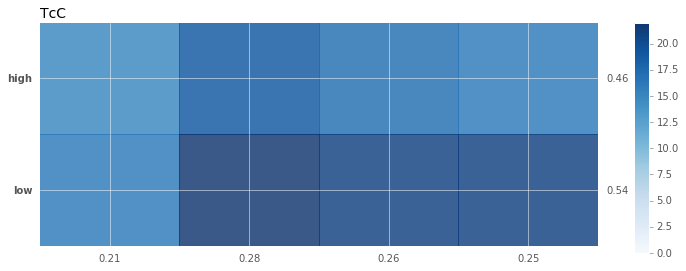

In [15]:
run_frequency_analysis('TcC',blocks_HL,blocks_LL,sequence_counts)

** <font color='blue'> LL Test complex + Construct more ($p < 0.05$) </font> **

But HL do not significantly Test simple and Pause more.

### Let's generalize these hypotheses and repeat the analysis for TP and TC
We merge all test actions (and don't ignore Test Other for this analysis)

In [16]:
merged_actions = {'C':'C', 'P':'P', 'Tb':'T', 'Tc':'T', 'Ts':'T', 'To':'T'}
blocks_T_HL, time_coords_T_HL =  get_blocks_withTime_new(df,students_HL,"Family",start=False,ignore=['I'], as_list=True)
blocks_T_LL, time_coords_T_LL =  get_blocks_withTime_new(df,students_LL,"Family",start=False,ignore=['I'], as_list=True)
blocks_T_Lpre, time_coords_T_Lpre =  get_blocks_withTime_new(df,students_Lpre,"Family",start=False,ignore=['I'], as_list=True)
actions_T = ['C','P','T']

Ttest_indResult(statistic=1.3551490870157352, pvalue=0.1796600458708642)
MannwhitneyuResult(statistic=814.5, pvalue=0.92263132085903377)


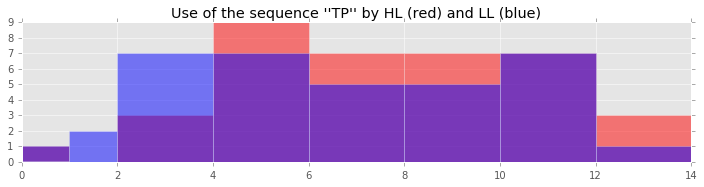

In [17]:
run_frequency_analysis_with_merge('TP',blocks_T_HL,blocks_T_LL,sequence_counts)

Ttest_indResult(statistic=-2.115443409198936, pvalue=0.038880124723732402)
MannwhitneyuResult(statistic=551.0, pvalue=0.075391730145363572)


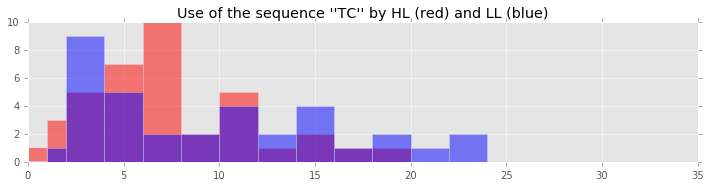

In [18]:
run_frequency_analysis_with_merge('TC',blocks_T_HL,blocks_T_LL,sequence_counts)

Visibly there is a trend however it is not significant. 
### Hypothesis 5.1 and 5.2: LL do more CP or PC?

Ttest_indResult(statistic=-1.5497227557396267, pvalue=0.12585054202615098)
MannwhitneyuResult(statistic=520.5, pvalue=0.038307193343822279)


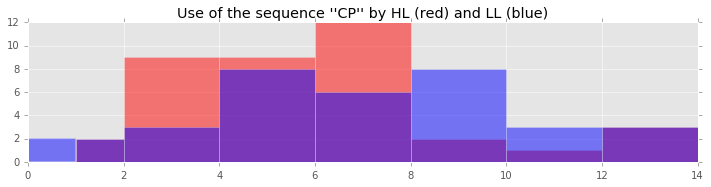

In [20]:
run_frequency_analysis_with_merge('CP',blocks_T_HL,blocks_T_LL,sequence_counts)

Ttest_indResult(statistic=-0.87960413154375494, pvalue=0.3821292173882429)
MannwhitneyuResult(statistic=610.5, pvalue=0.21349556544094106)


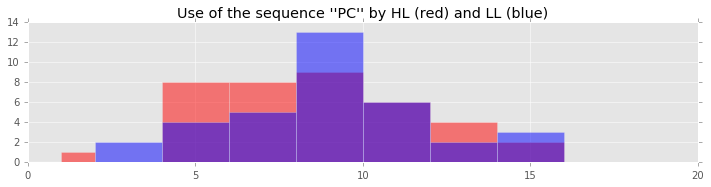

In [21]:
run_frequency_analysis_with_merge('PC',blocks_T_HL,blocks_T_LL,sequence_counts)

Once again, visisbly there is a trend however it is not significant.
## So everyone pauses during the activity, but they possibly use pauses differently...

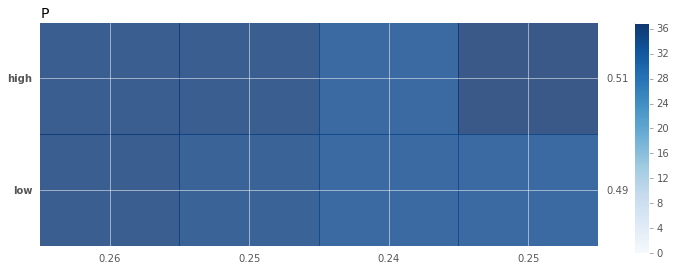

In [24]:
plot = plot_heat_map(sequence_counts['P'],'P',('high','low'))

TPC
TPC :	Ttest_indResult(statistic=1.7153956899765392, pvalue=0.090576966942790341)
	HL<LL MannwhitneyuResult(statistic=832.0, pvalue=0.94795354624198147)
	HL>LL MannwhitneyuResult(statistic=832.0, pvalue=0.053222295912240238)
CPT
CPT :	Ttest_indResult(statistic=0.56029113733926694, pvalue=0.5770314029619783)
	HL<LL MannwhitneyuResult(statistic=744.0, pvalue=0.74858786741500749)
	HL>LL MannwhitneyuResult(statistic=744.0, pvalue=0.2549551593533444)
TPT
TPT :	Ttest_indResult(statistic=0.74999047416987941, pvalue=0.45571469560768596)
	HL<LL MannwhitneyuResult(statistic=736.0, pvalue=0.71807811791411447)
	HL>LL MannwhitneyuResult(statistic=736.0, pvalue=0.28564642303622079)
CPC
CPC :	Ttest_indResult(statistic=-1.7848614413484243, pvalue=0.078838675159720276)
	HL<LL MannwhitneyuResult(statistic=528.0, pvalue=0.044559789261138232)
	HL>LL MannwhitneyuResult(statistic=528.0, pvalue=0.9564588151782013)


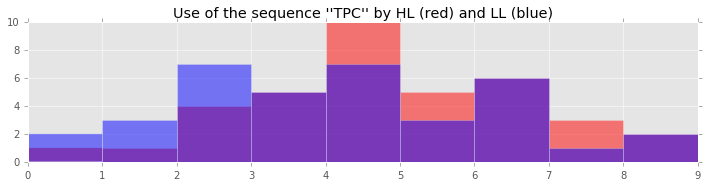

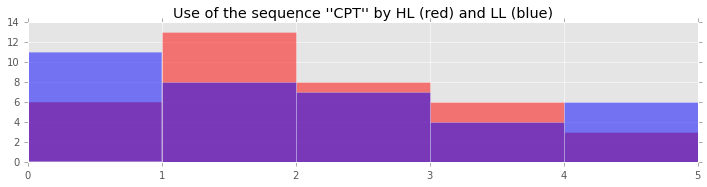

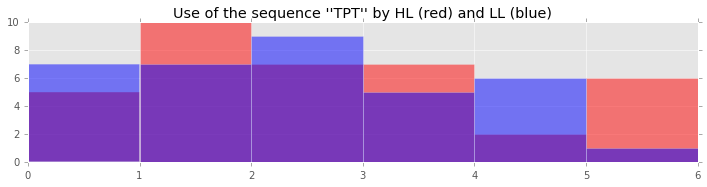

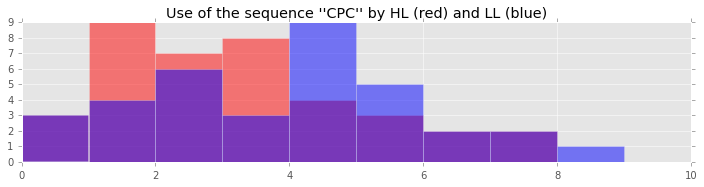

In [45]:
for seq in ['TPC','CPT','TPT','CPC']:
    print seq
    run_frequency_analysis_with_merge(seq,blocks_T_HL,blocks_T_LL,sequence_counts)